# The full POSYDON Processing Pipeline experience

From A to Z: in this tutorial you learn to run all steps of the POSYDON post processing pipeline. This includes:
- step 1: create the h5 file of each MESA grid, this includes the base grid and any expansion or rerun
- step 2: stack the grids together by concatenating them in the correct order
- step 2 plot: plot 2D grid slices to visualize termination flags, final values and other properties
- step 2 check failure rate: check the failure rate of the grid
- step 3: compute post processing values on the ORIGINAL grid (these values are stored as additional final values columns)
- step 4: train the initial final interpolators and classifiers
- step F: export the entire POSYDON dataset in the working directory 

All these steps are linked together and, when possible, they will be executed in parallel, else sequentially.

We support two types of compression LITE and ORIGINAL, the former resamples the stellar histories, the binary history and the final stellar profile. Please refer to the POSYDON v1.0.0 paper for more details.

We illustrate this example using the 100 HMS-HMS MESA models which we refer to as the `test_grid` and the opacity_max rerun layer, `rerun_opacity_max_test_grid`, we generated by rerunning failed models in the `test_grid` with a lower higher opacity max limit as illustrative `fix`.

## Preparing the Pipeline initialization file

The following cell exports the entire `pipeline.ini`, the purpose of this tutorial is to get you acquainted with the pipeline and not to teach you how to export the entire POSYDON v2.0.0 dataset. 

EXTRA: If you are a POSYDON developer or just a curious person, you can find the full POSYDON v2.0.0 `pipeline.ini` file in `$PATH_TO_POSYDON/grid_params/pipeline_quest.ini` and `$PATH_TO_POSYDON/grid_params/pipeline_yggdrasil.ini`. At the time of writing this tutorial we support 5 layers of reruns and store the raw MESA data of v2.0.0 across two HPC facilities. Exporting the entire v2.0.0 dataset from start to finish might require more than 24 hours computing time. !!! WARNING !!! before exporting the entire POSYDON v2.0.0 dataset, make sure you know what you are doing! 

Now sit back, relax and enjoy the POSYDON experience!

In [ ]:
%%writefile pipeline.ini
[account]
    ACCOUNT = 'meynet'
    PARTITION = 'public-cpu'
    WALLTIME = '06:00:00'
    MAILTYPE = 'ALL'
    EMAIL = 'simone.bavera@unige.ch'

[pipeline setup]
    PATH_TO_GRIDS = '/srv/beegfs/scratch/shares/astro/posydon/POSYDON_GRIDS_v2/POSYDON_data/230914/POSYDON_data/tutorials/processing-pipeline/'
    VERSION = '' # to have a version below the grid type level
    PATH = '.' # working dir
    VERBOSE = True
    
    # steps
    CREATE_GRID_SLICES = True
    COMBINE_GRID_SLICES = True
    CALCULATE_EXTRA_VALUES = True
    TRAIN_INTERPOLATORS = True
    EXPORT_DATASET = True
    # rerun step
    RERUN = False

#CREATE_GRID_SLICES
[step_1]
    # e.g. ['CO-HMS_RLO','CO-HeMS','HMS-HMS']
    GRID_TYPES = ['HMS-HMS']
    # e.g. ['2e+00_Zsun', '1e+00_Zsun', '4.5e-01_Zsun', '2e-01_Zsun', '1e-01_Zsun', '1e-02_Zsun', '1e-03_Zsun', '1e-04_Zsun']
    METALLICITIES = [
                     # HMS-HMS
                     ['1e-01_Zsun']
                    ]
    GRID_SLICES = [
                   # HMS-HMS
                   ['test_grid', 'rerun_opacity_max_test_grid']
                  ]
    COMPRESSIONS = [
                    # HMS-HMS
                    ['LITE', 'ORIGINAL']
                   ]
    DROP_MISSING_FILES = True
    # EXTRA PARAMETERS
    # only applied to HMS grids
    STOP_BEFORE_CARBON_DEPLETION = 1
    # supported plots: e.g. 'combined_TF12', 'termination_flag_1', 'termination_flag_2', 'termination_flag_3', 'termination_flag_4', and any quantity valid for a Z-plotting
    CREATE_PLOTS = []
    # supported checks: e.g. 'failure_rate'
    DO_CHECKS = []

#COMBINE_GRID_SLICES
[step_2]
    GRID_TYPES = ['HMS-HMS']
    METALLICITIES = [# HMS-HMS
                     ['1e-01_Zsun']
                    ]
    GRID_SLICES = [
                   # HMS-HMS
                   [['test_grid', 'rerun_opacity_max_test_grid']]
                  ]
    GRIDS_COMBINED = [
                      # HMS-HMS
                      ['grid_test_combined']
                     ]
    COMPRESSIONS = [
                    # HMS-HMS
                    ['LITE', 'ORIGINAL']
                   ]
    DROP_MISSING_FILES = True
    # supported plots: e.g. 'combined_TF12', 'termination_flag_1', 'termination_flag_2', 'termination_flag_3', 'termination_flag_4', and any quantity valid for a Z-plotting
    CREATE_PLOTS = ['PLOT_AFTER_COMBINE']
    # supported checks: e.g. 'failure_rate'
    DO_CHECKS = ['CHECK_AFTER_COMBINE']

#CALCULATE_EXTRA_VALUES
[step_3]
    GRID_TYPES = ['HMS-HMS']
    METALLICITIES = [# HMS-HMS
                     ['1e-01_Zsun']
                    ]
    GRID_SLICES = [# HMS-HMS
                   ['grid_test_combined']
                  ]
    COMPRESSIONS = [
                    # HMS-HMS
                    ['LITE']
                   ]
    DROP_MISSING_FILES = True
    # supported plots: e.g. 'combined_TF12', 'termination_flag_1', 'termination_flag_2', 'termination_flag_3', 'termination_flag_4', and any quantity valid for a Z-plotting
    CREATE_PLOTS = ['PLOT_AFTER_EXTRA']
    # supported checks: e.g. 'failure_rate', 'CO_TYPE', 'SN_TYPE'
    DO_CHECKS = ['CHECK_AFTER_EXTRA']

#TRAIN_INTERPOLATORS
[step_4]
    GRID_TYPES = ['HMS-HMS']
    METALLICITIES = [# HMS-HMS
                     ['1e-01_Zsun']
                    ]
    GRID_SLICES = [# HMS-HMS
                   ['grid_test_combined_processed']
                  ]
    INTERPOLATION_METHODS = ["linear","1NN"]
    COMPRESSIONS = [
                    # HMS-HMS
                    ['LITE']
                   ]
    CONTROL_GRIDS = [
                     # HMS-HMS
                     ['grid_test_combined'] # if available this should be a randomly sampled grid
                    ]
    DROP_MISSING_FILES = True
    # supported plots: e.g. 'combined_TF12', 'termination_flag_1', 'termination_flag_2', 'termination_flag_3', 'termination_flag_4', and any quantity valid for a Z-plotting
    CREATE_PLOTS = ['PLOT_AFTER_TRAINING']
    # supported checks: e.g. 'failure_rate'
    DO_CHECKS = ['CHECK_AFTER_TRAINING']

#EXPORT_DATASET
[step_F]
    GRID_TYPES = ['HMS-HMS']
    METALLICITIES = [# HMS-HMS
                     ['1e-01_Zsun']
                    ]
    GRID_SLICES = [
                   # HMS-HMS
                   ['grid_test_combined_processed']
                  ]
    COMPRESSIONS = [
                    # HMS-HMS
                    ['LITE']
                   ]
    DROP_MISSING_FILES = True

#EXPORT_RERUNS
[rerun]
    GRID_TYPES = ['HMS-HMS']
    METALLICITIES = [# HMS-HMS
                     [ '1e-01_Zsun']
                    ]
    GRID_SLICES = [
                   # HMS-HMS
                   ['grid_test_combined'],
                  ]
    COMPRESSIONS = [
                    # HMS-HMS
                    ['LITE']
                   ]
    DROP_MISSING_FILES = True
    # example reruns are 'PISN', 'reverse_MT', 'opacity_max', 'TPAGBwind'
    RERUN_TYPE = None


Overwriting pipeline.ini


## Setting-up and Running the Post Processing Pipeline

We are all set, let's set up the pipeline and run it!

In [68]:
!posydon-setup-pipeline pipeline.ini

/home/bavera/.conda/envs/posydon_env/bin/posydon-setup-pipeline:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('posydon==1.0.0+194.g3953a14')

+++++++++++++++++++ACCOUNT+++++++++++++++++++ 
{ 'ACCOUNT': 'meynet',
  'EMAIL': 'simone.bavera@unige.ch',
  'MAILTYPE': 'ALL',
  'PARTITION': 'public-cpu',
  'WALLTIME': '06:00:00'}

++++++++++++++++++++SETUP++++++++++++++++++++
{ 'CALCULATE_EXTRA_VALUES': True,
  'COMBINE_GRID_SLICES': True,
  'CREATE_GRID_SLICES': True,
  'EXPORT_DATASET': True,
  'PATH': '.',
  'PATH_TO_GRIDS': '/srv/beegfs/scratch/shares/astro/posydon/POSYDON_GRIDS_v2/POSYDON_data/230914/POSYDON_data/tutorials/processing-pipeline/',
  'RERUN': False,
  'TRAIN_INTERPOLATORS': True,
  'VERBOSE': True,
  'VERSION': ''}


-------------CREATE_GRID_SLICES--------------  step_1 : True 
{ 'COMPRESSIONS': [['LITE', 'ORIGINAL']],
  'CREATE_PLOTS': [],
  'DO_CHECKS': [],
  

In [29]:
!ls

logs			  step_2.csv	       step_3.slurm
pipeline.ini		  step_2_plots.csv     step_4.csv
POSYDON_data		  step_2_plots.slurm   step_4_plots.csv
run_full_piepeline.ipynb  step_2.slurm	       step_4_plots.slurm
run_pipeline.sh		  step_3_checks.csv    step_4.slurm
step_1.csv		  step_3_checks.slurm  step_F.csv
step_1.slurm		  step_3.csv	       step_F.slurm
step_2_checks.csv	  step_3_plots.csv
step_2_checks.slurm	  step_3_plots.slurm


Data will be exported in the `POSYDON_data/` directory once the pipeline is done. You can keep track of the progress by checking the log files of each step in the `logs/` directory. Let's submit the entire pipeline with the shell script.

In [30]:
!./run_pipeline.sh

step_1.slurm submitted as 28474240
step_2.slurm submitted as 28474241
step_2_plots.slurm submitted as 28474242
step_2_checks.slurm submitted as 28474243


step_3.slurm submitted as 28474244
step_3_plots.slurm submitted as 28474245
step_3_checks.slurm submitted as 28474246
step_4.slurm submitted as 28474247
step_4_plots.slurm submitted as 28474248
step_F.slurm submitted as 28474249


In [33]:
!squeue -u bavera

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
        28473967_1 private-a mesa_gri   bavera  R    5:13:52      1 cpu144
        28473967_4 private-a mesa_gri   bavera  R    5:13:52      1 cpu144
        28473967_5 private-a mesa_gri   bavera  R    5:13:52      1 cpu144
        28473967_7 private-a mesa_gri   bavera  R    5:13:52      1 cpu144
    28474249_[0-2] public-cp psygrid9   bavera PD       0:00      1 (Dependency)
    28474248_[0-1] public-cp psygrid4   bavera PD       0:00      1 (Dependency)
    28474247_[0-1] public-cp psygrid4   bavera PD       0:00      1 (Dependency)
      28474246_[0] public-cp psygrid3   bavera PD       0:00      1 (Dependency)
      28474245_[0] public-cp psygrid3   bavera PD       0:00      1 (Dependency)
      28474244_[0] public-cp psygrid3   bavera PD       0:00      1 (Dependency)
    28474243_[0-1] public-cp psygrid2   bavera PD       0:00      1 (Dependency)
      28474242_[0] public-cp psygrid2   bavera P

### Exploring the visualization outputs

While we wait for the entire pipeline to finish we can explore the plots which we find in `PATH_TO_GRIDS/HMS-HMS/1e-01_Zsun/plots/GRID_NAME`.

In [61]:
!ls /srv/beegfs/scratch/shares/astro/posydon/POSYDON_GRIDS_v2/POSYDON_data/230914/POSYDON_data/tutorials/processing-pipeline/HMS-HMS/1e-01_Zsun/plots/grid_test_combined_processed/S1_MODEL01/

CO_type  mass  m_disk_radiated	SN_type  spin


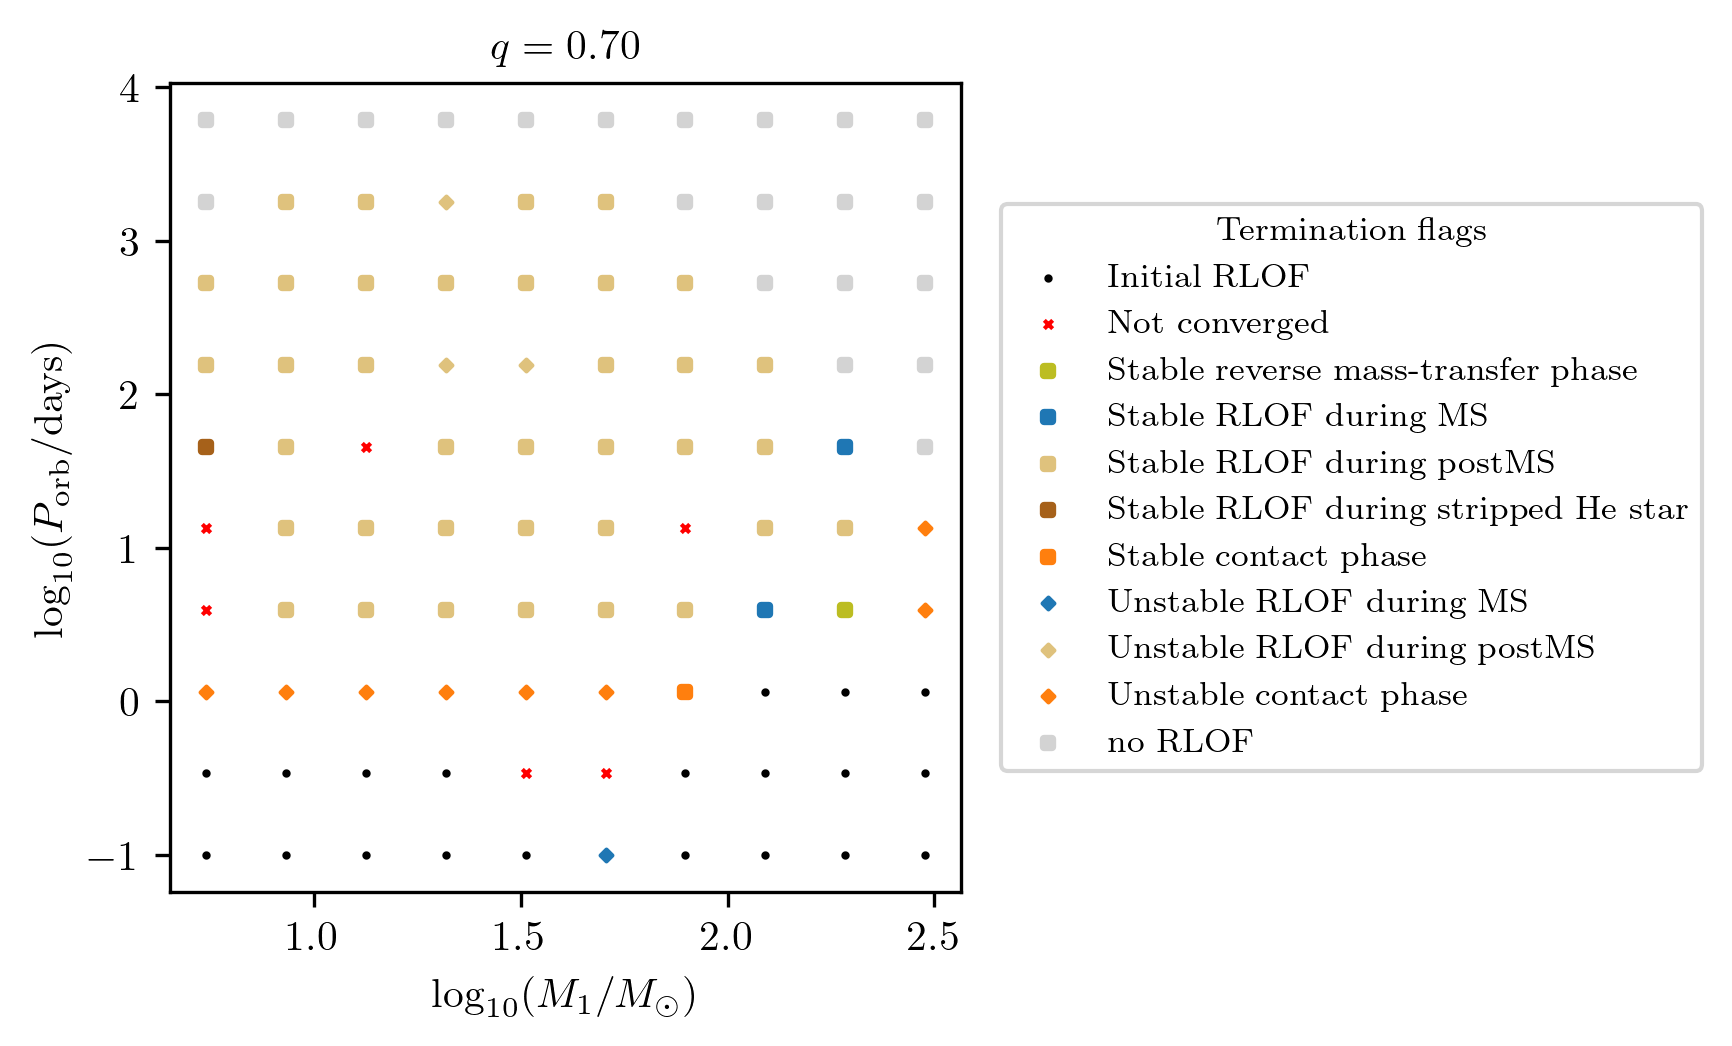

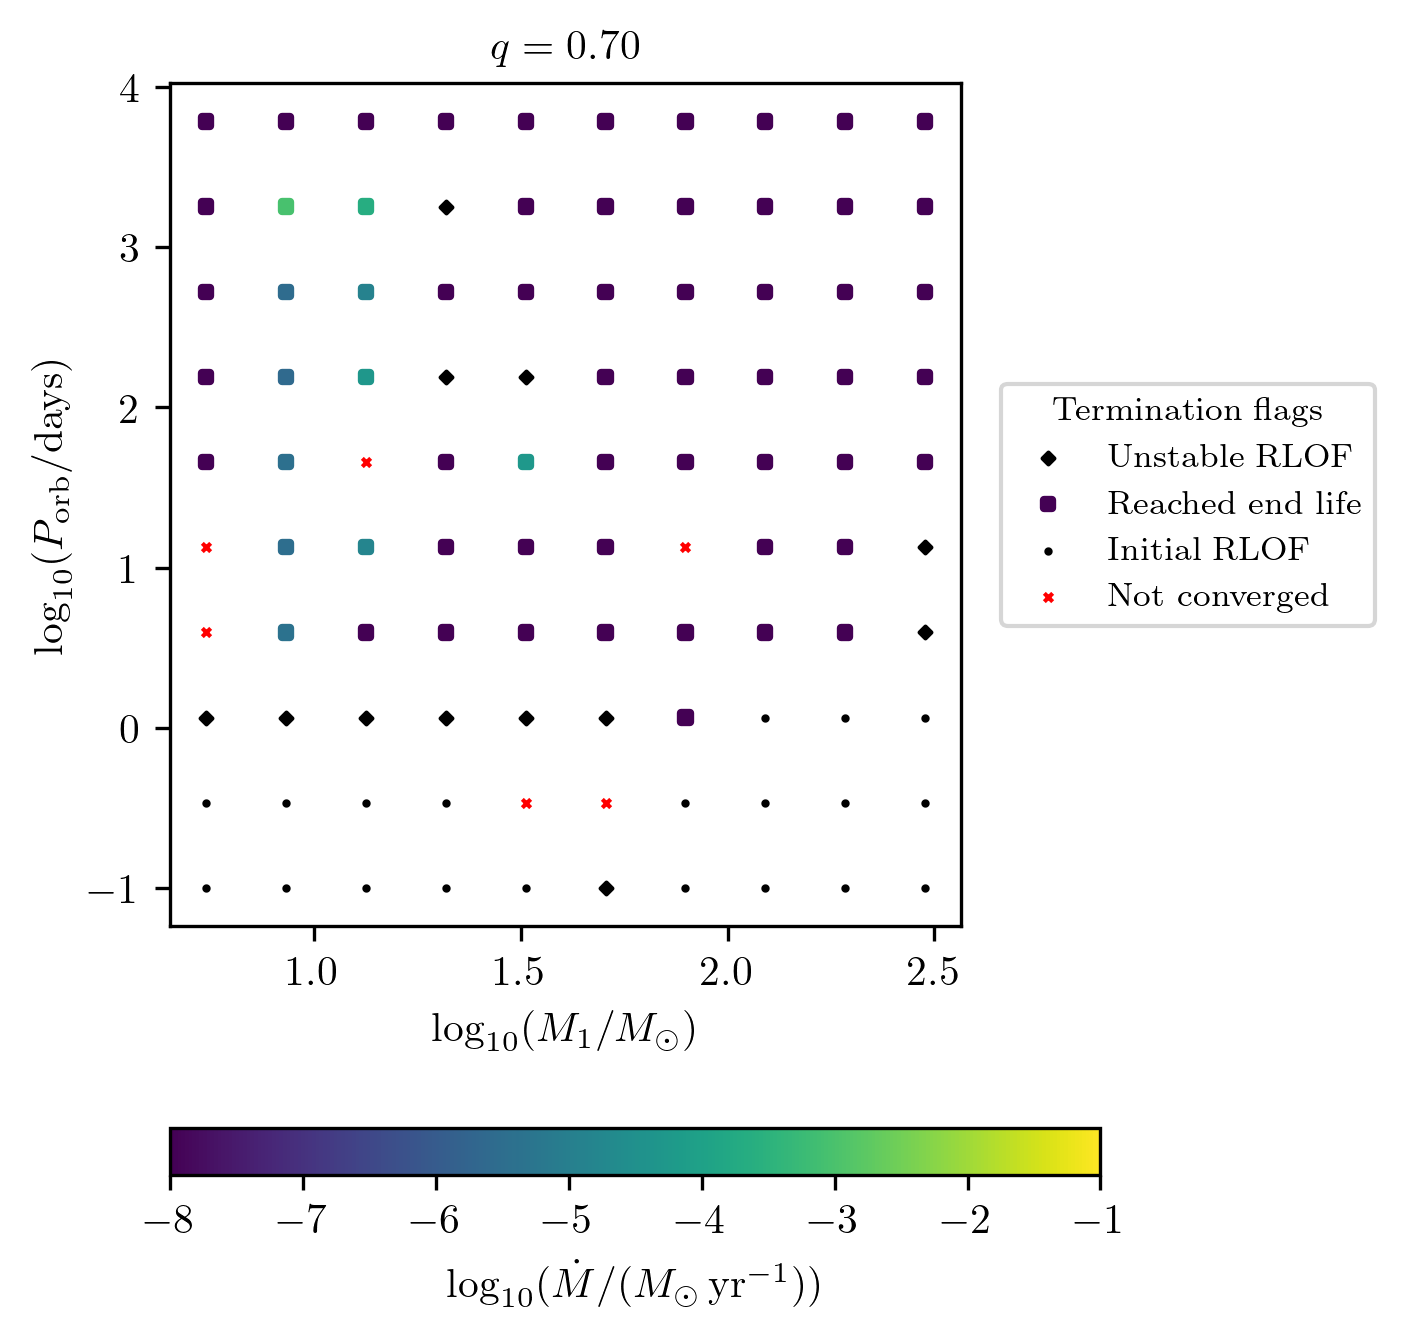

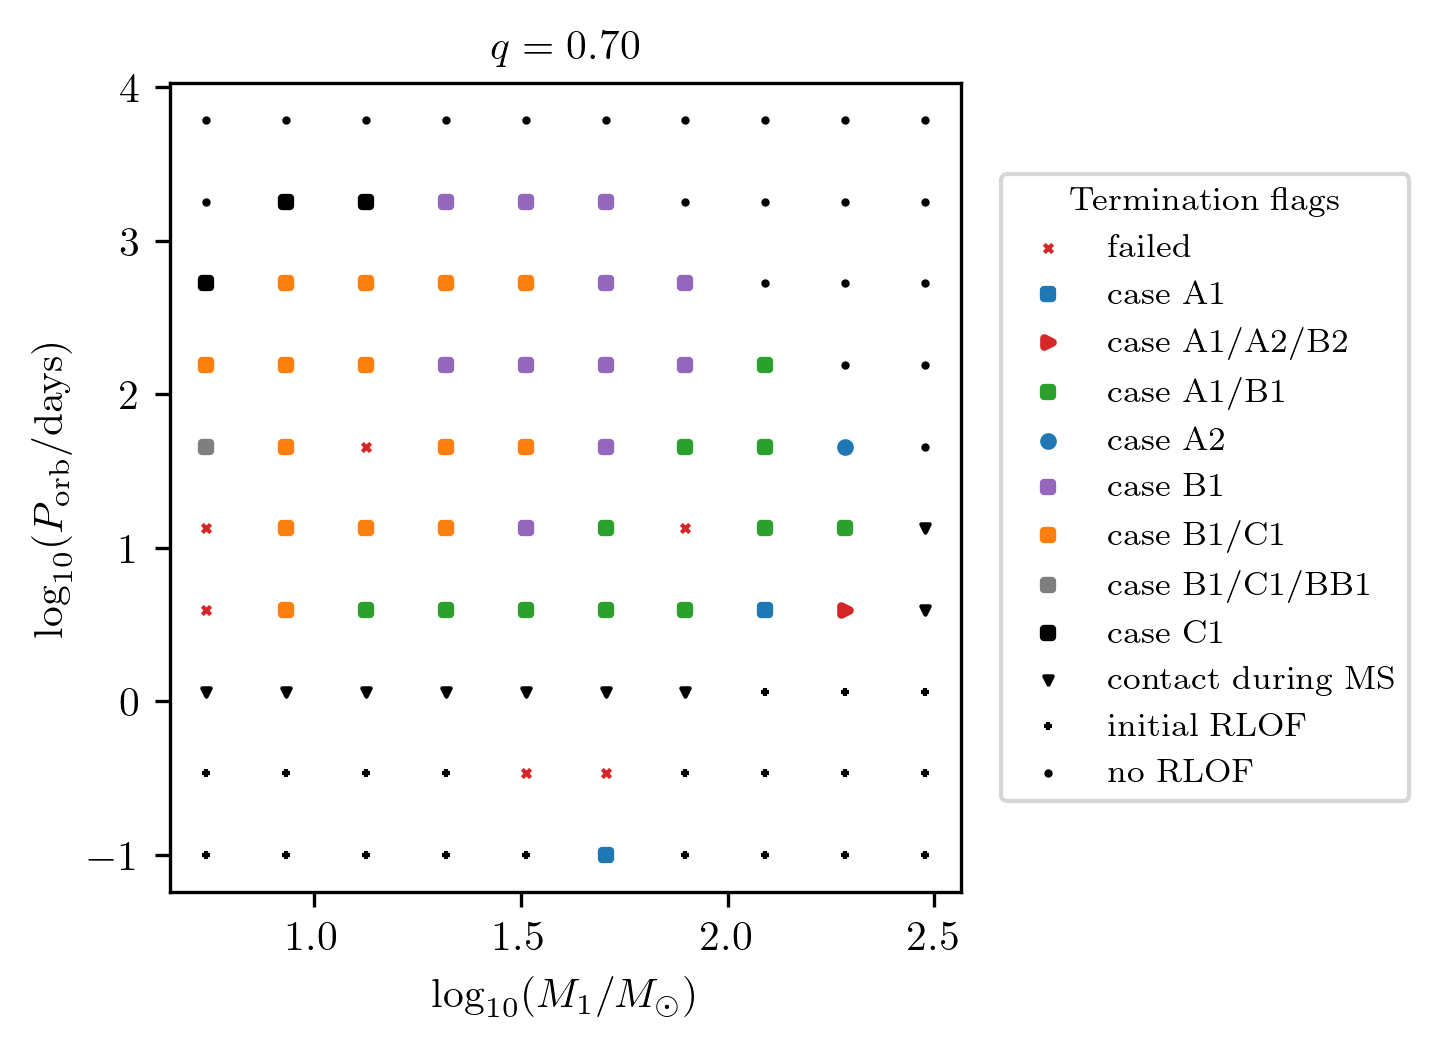

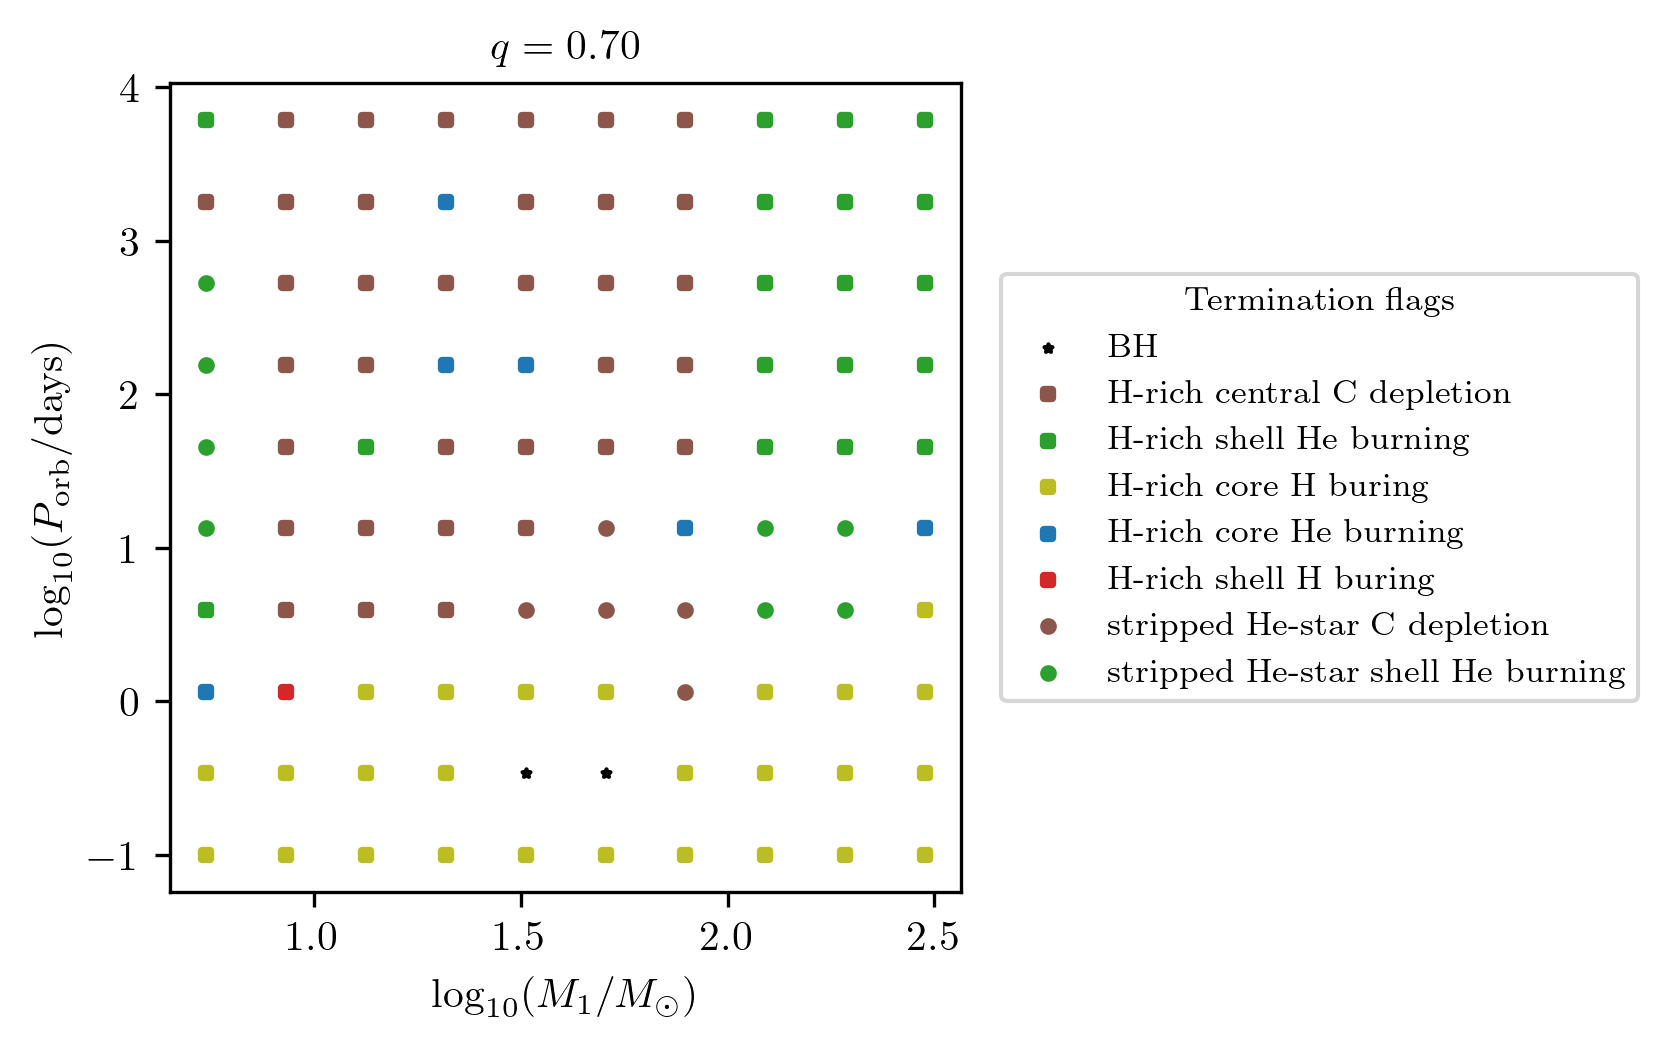

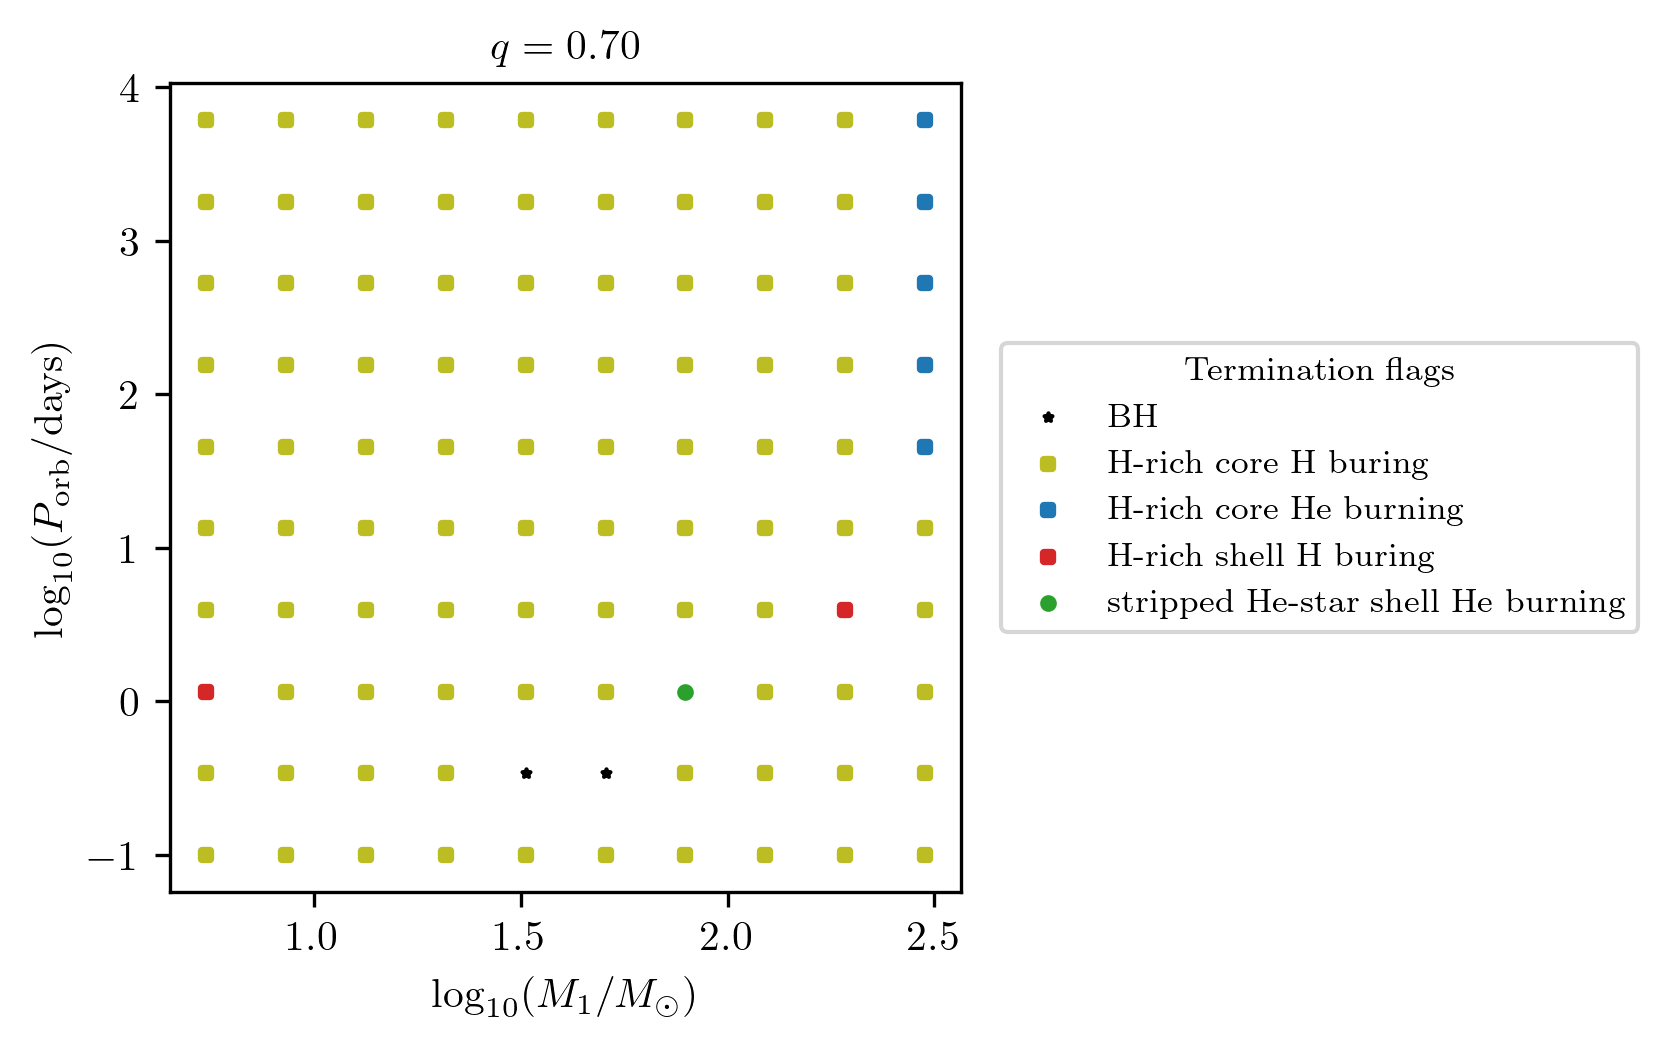

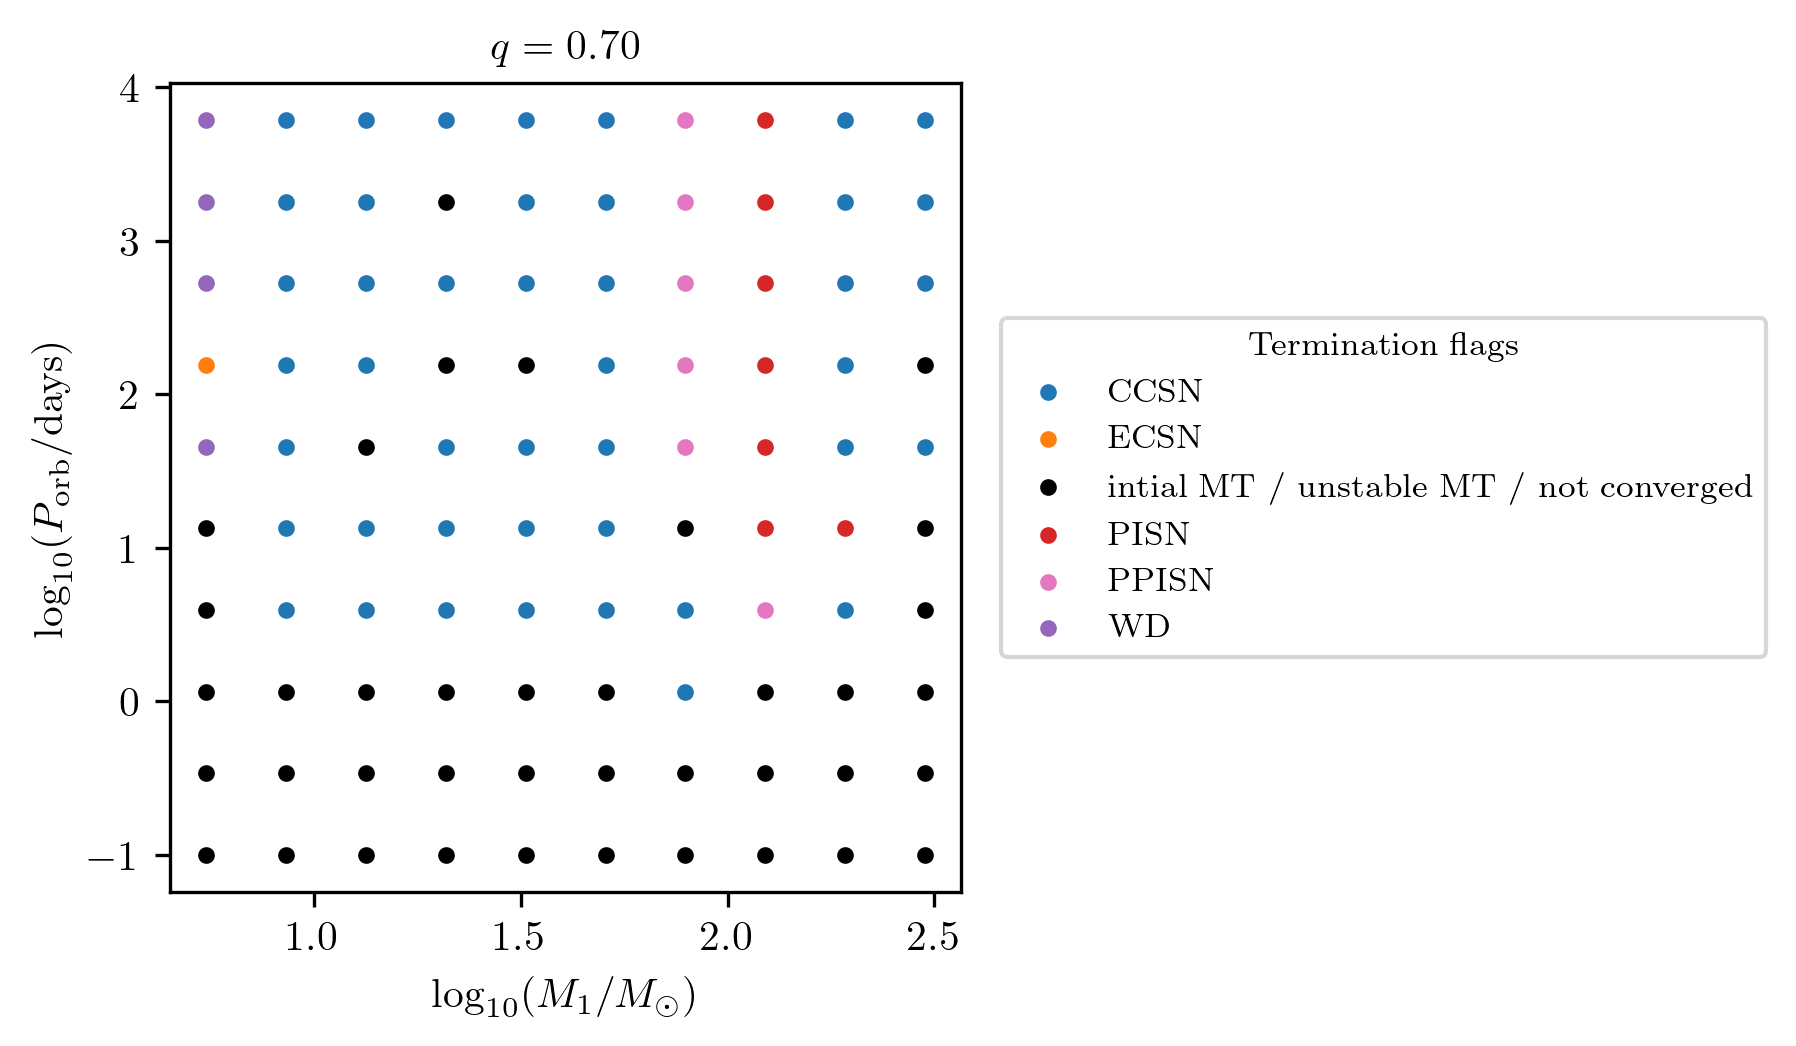

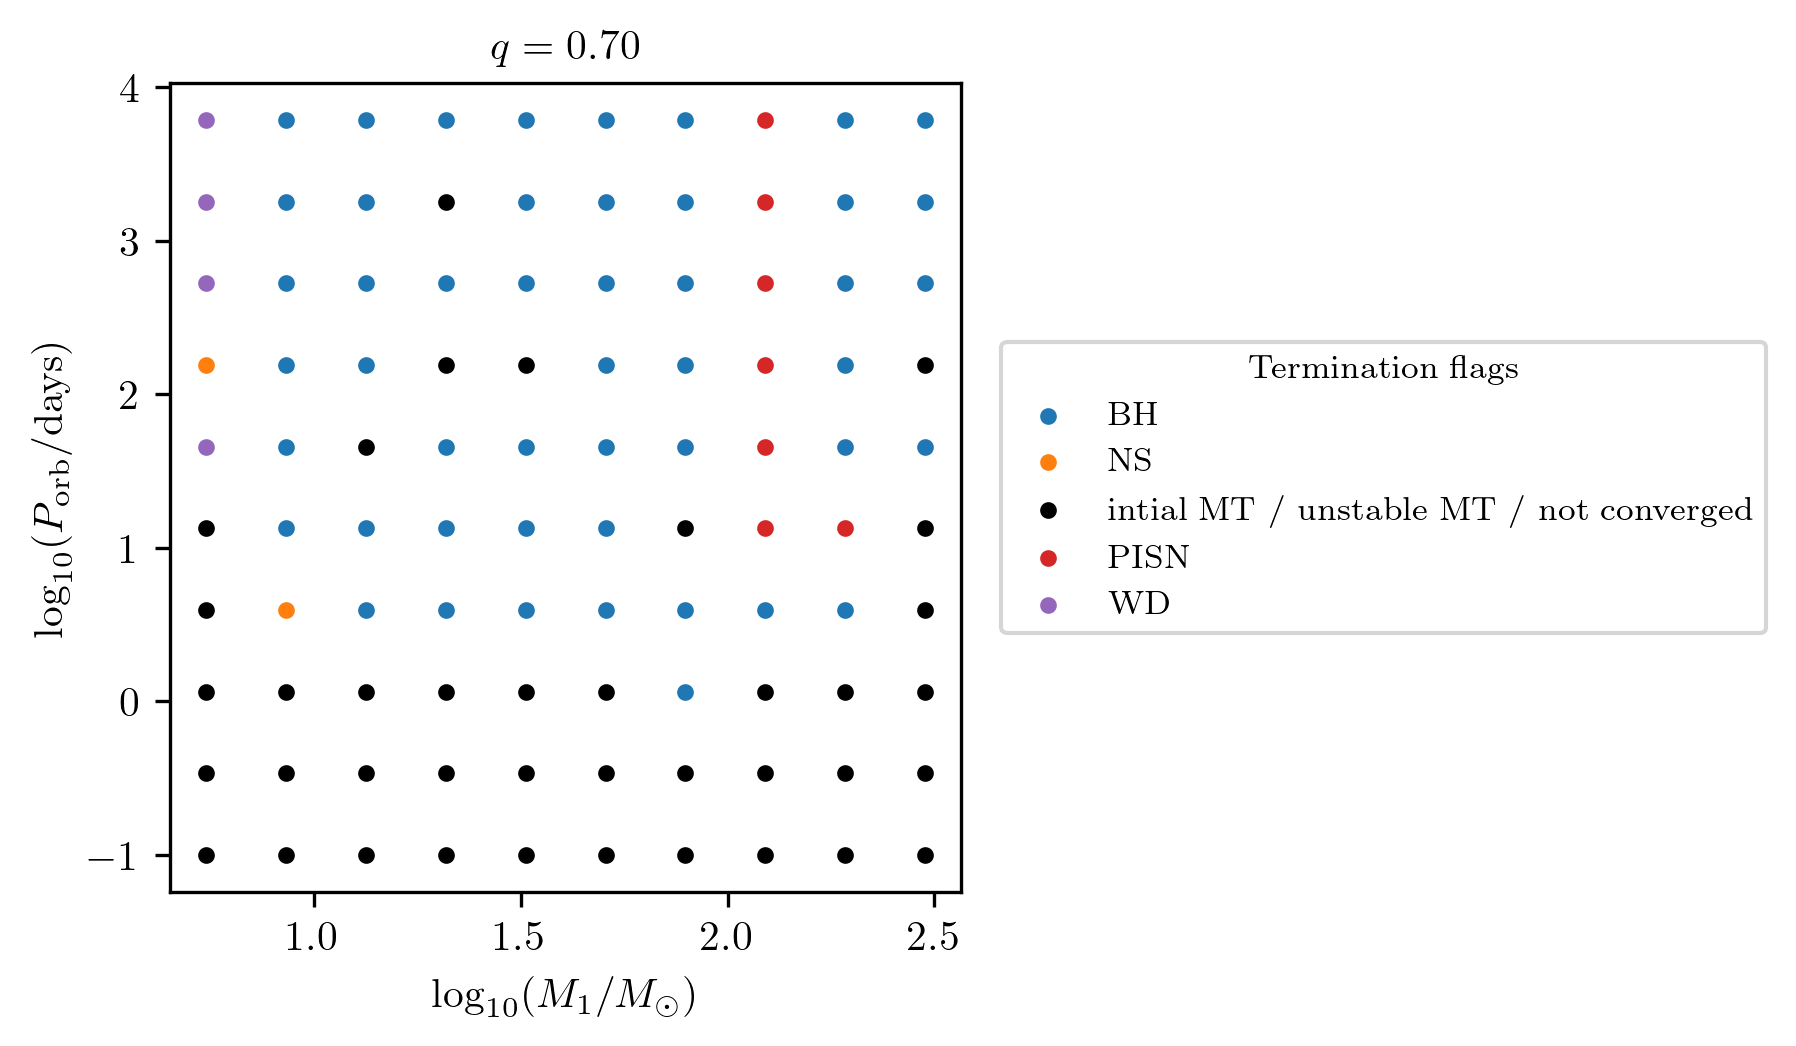

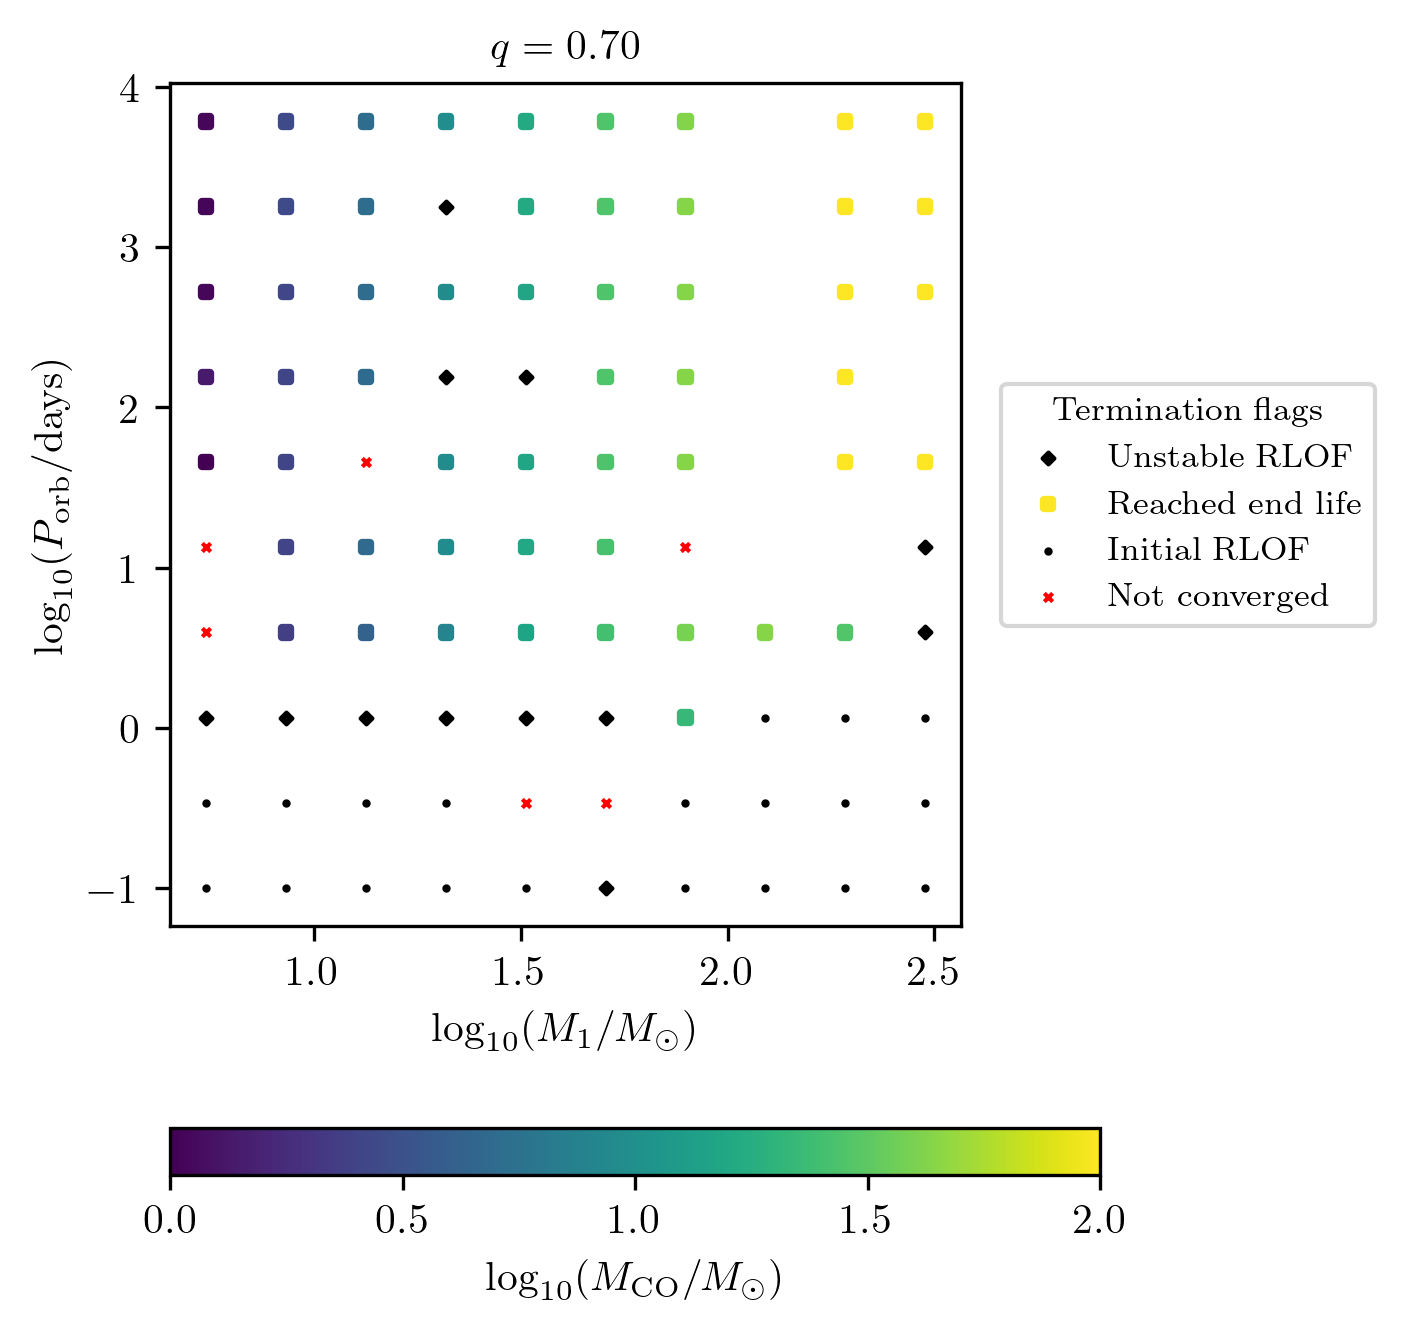

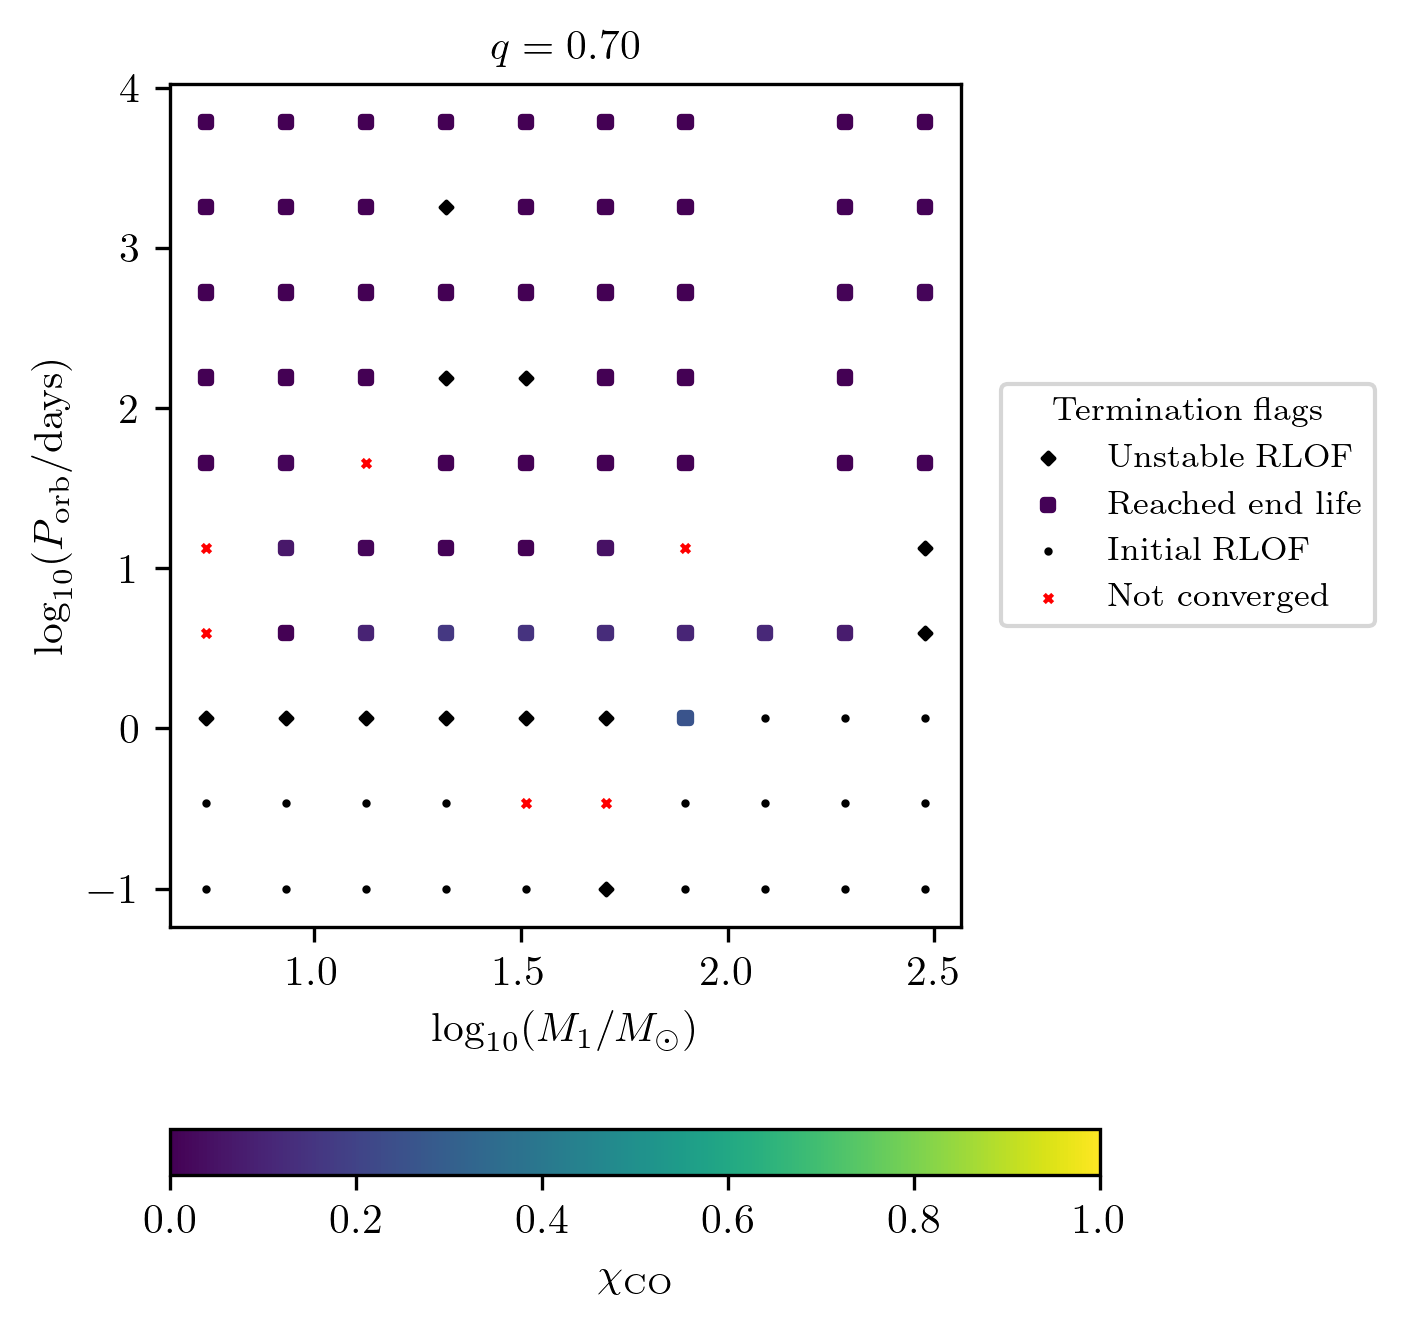

In [63]:
from IPython.display import display, Image
path = '/srv/beegfs/scratch/shares/astro/posydon/POSYDON_GRIDS_v2/POSYDON_data/230914/POSYDON_data/tutorials/processing-pipeline/HMS-HMS/1e-01_Zsun/plots/'
# termination flags
img = Image(path+'grid_test_combined/TF12/grid_q_0.70.png')
display(img)
img = Image(path+'grid_test_combined/TF1/grid_q_0.70.png')
display(img)
img = Image(path+'grid_test_combined/TF2/grid_q_0.70.png')
display(img)
img = Image(path+'grid_test_combined/TF3/grid_q_0.70.png')
display(img)
img = Image(path+'grid_test_combined/TF4/grid_q_0.70.png')
display(img)
# processed values
img = Image(path+'grid_test_combined_processed/S1_MODEL01/SN_type/grid_q_0.70.png')
display(img)
img = Image(path+'grid_test_combined_processed/S1_MODEL01/CO_type/grid_q_0.70.png')
display(img)
img = Image(path+'grid_test_combined_processed/S1_MODEL01/mass/grid_q_0.70.png')
display(img)
img = Image(path+'grid_test_combined_processed/S1_MODEL01/spin/grid_q_0.70.png')
display(img)


In this tutorial we did not create a randomly sampled grid to test the accuracy of the interpolators. If you create a randomly sampled grid, then the pipeline will also export 2D error maps evaluated on the randomly sampled grid. This is left as an exercise to the reader. 

TODO: add the automatic export of violin plots and confusion matrices to the plotting.

Check that you obtained the dataset.

In [80]:
!ls POSYDON_data/HMS-HMS/

1e-01_Zsun.h5  interpolators


Congratulations you have completed the POSYDON v2.0.0 pipeline tutorial!